In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
X, y = mnist["data"], mnist["target"]

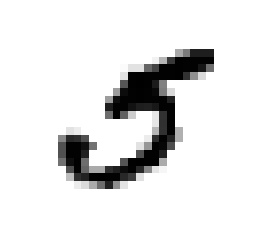

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
# Let’s also shuffle the training set; this will guarantee that all cross-validation folds 
# will be similar (you don’t want one fold to be missing some digits). Moreover, some 
# learning algorithms are sensitive to the order of the training instances, and they perform 
# poorly if they get many similar instances in a row.
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Training a binary classifier
===============

First implement a detector. A classifier who can distinguish between 5 and non-5.

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

Implementing cross-validation
===============

K-Folds cross validation splits data into K parts and trains the model
on a partition of (K-1) parts of the data and tests it on the remaining part.

Repeats this process K times, and outputs how well the model did each time.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print (n_correct / len(y_pred))
    
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

0.9635
0.954
0.95265


array([ 0.9635 ,  0.954  ,  0.95265])

A much better way to evaluate the performance of a classifier is to look at the **confusion matrix**.

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[52859,  1720],
       [  877,  4544]], dtype=int64)

In [12]:
from sklearn.metrics import precision_score, recall_score

ps = precision_score(y_train_5, y_train_pred)
rs = recall_score(y_train_5, y_train_pred)
print(ps)
print(rs)

0.725415070243
0.838221730308


In [13]:
f1 = 2 * (ps * rs) / (ps + rs)
print(f1)

0.777749251177


In [14]:
y_scores = sgd_clf.decision_function([some_digit])
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [15]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

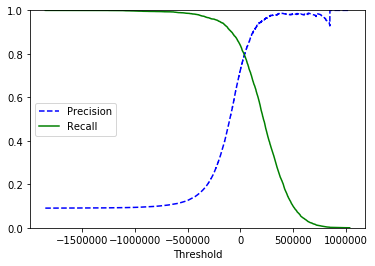

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [18]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.84059467272351851

The ROC Curve
=======

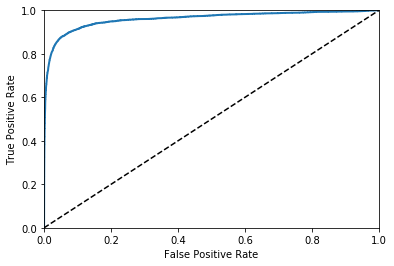

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [20]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.96078005951200107

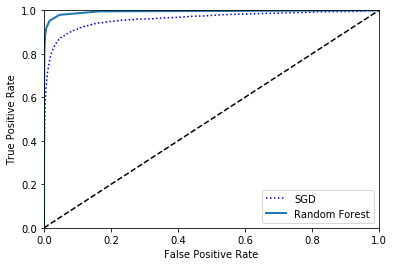

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [22]:
roc_auc_score(y_train_5, y_scores_forest)

0.99392796414894014

In [23]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [24]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -28768.14073475, -389360.18385759, -387035.22402535,
        -249981.51610088, -288766.25090922,   93437.08302367,
        -723100.13731589, -168143.27361228, -943350.15176607,
        -515149.27309047]])

In [25]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [26]:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0. ,  0.2,  0. ,  0.7,  0. ,  0. ,  0.1,  0. ]])

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91021796,  0.90689534,  0.90978647])

In [30]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5732,    3,   25,    9,   12,   40,   48,    7,   42,    5],
       [   2, 6464,   48,   25,    4,   46,    8,   13,  115,   17],
       [  55,   40, 5325,  107,   87,   23,   97,   52,  155,   17],
       [  55,   37,  133, 5353,    1,  219,   36,   56,  139,  102],
       [  20,   30,   39,    6, 5345,    7,   55,   29,   81,  230],
       [  72,   38,   32,  198,   69, 4598,  118,   27,  173,   96],
       [  31,   30,   46,    2,   33,   85, 5640,    6,   45,    0],
       [  24,   25,   67,   26,   62,   11,    7, 5772,   14,  257],
       [  55,  162,   65,  160,   18,  155,   58,   25, 4999,  154],
       [  39,   31,   29,   86,  146,   37,    2,  186,   83, 5310]], dtype=int64)

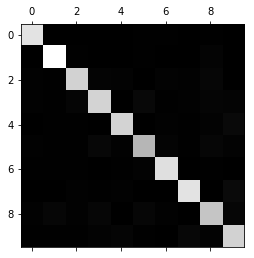

In [32]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

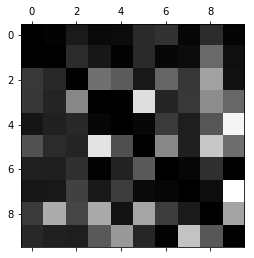

In [33]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()